In [89]:
from enum import Enum
from pathlib import Path
from itertools import chain
from matplotlib import pyplot as plt

import numpy as np
import cv2

from skimage import feature
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, plot_confusion_matrix, classification_report
from sklearn.ensemble import AdaBoostClassifier

np.random.seed(42)

TFEID_COLOR_PATH = Path('data/dfh_all/dfh_color/')

class Expression(Enum):
    ANGER = 1
    CONTEMPT = 2
    DISGUST = 3 
    FEAR = 4
    HAPPINESS = 5
    NEUTRAL = 6
    SADNESS = 7
    SURPRISE = 8

folder = {
    Expression.ANGER     : Path('dfh_anger_c'),
    Expression.CONTEMPT  : Path('dfh_contempt_c'),
    Expression.DISGUST   : Path('dfh_disguest_c'),
    Expression.FEAR      : Path('dfh_fear_c'),
    Expression.HAPPINESS : Path('dfh_happiness_c'),
    Expression.NEUTRAL   : Path('dfh_neutral_c'),
    Expression.SADNESS   : Path('dfh_sadness_c'),
    Expression.SURPRISE  : Path('dfh_surprise_c'),
}    
    
def read_images_expr(path:Path, expr:Expression):
    images = []
    labels = []
    expr_path = path.joinpath(folder[expr])
    for img_path in expr_path.iterdir():
        img = cv2.imread(str(img_path), cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)
        labels.append(expr.value)
    return images, labels

def read_images(path):
    images, labels = [], []
    for expr in Expression:
        expr_images, expr_labels = read_images_expr(path, expr=expr)
        print(expr, len(expr_images), len(expr_labels))
        images+=expr_images
        labels+=expr_labels
    return images, labels

tfeid_images, tfeid_labels = read_images(TFEID_COLOR_PATH)

Expression.ANGER 34 34
Expression.CONTEMPT 68 68
Expression.DISGUST 40 40
Expression.FEAR 40 40
Expression.HAPPINESS 40 40
Expression.NEUTRAL 39 39
Expression.SADNESS 39 39
Expression.SURPRISE 36 36


In [92]:
np.random.seed(42)

""" TO DO """
def preprocess_single(img):
#     img = cv2.resize(img, (480,600))
    img = cv2.resize(img, (600,600))
    return img

def preprocess(images):
    return np.array([preprocess_single(img) for img in images])
    
def hog(img):
    fd = feature.hog(img, orientations=8,
                     pixels_per_cell=(16,16),
                     cells_per_block=(4,4),
                     block_norm='L2',
                     feature_vector=True)
    hist, _ = np.histogram(
        fd.ravel(),
        bins= 100,
    )

    hist = hist.astype(np.float)
    hist /= (np.sum(hist)+1e-5)

    return hist

def lbp(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    numpoints = 24
    radius = 8
    lbp = feature.local_binary_pattern(img, numpoints, radius)
    hist, _ = np.histogram(
        lbp.ravel(),
        bins= numpoints+3,
    )

    hist = hist.astype(np.float)
    hist /= (np.sum(hist)+1e-5)

    return hist


def extract_features(images, method):
    return np.array([method(img) for img in images])
#     return np.vectorize(method)(images)


tfeid_x = preprocess(tfeid_images)
tfeid_x = extract_features(tfeid_x, method=hog)
tfeid_labels = np.array(tfeid_labels)

train_x, test_x, train_y, test_y = train_test_split(tfeid_x, tfeid_labels, stratify=tfeid_labels)

In [39]:
np.random.seed(42)

# 'rbf', 'sigmoid'
param_grid = {
    'base_estimator':[DecisionTreeClassifier(max_depth=10)],
    'learning_rate':np.logspace(-3, 2, 25, base = 10),
}

grid_search = GridSearchCV(AdaBoostClassifier(), param_grid=param_grid, verbose=True, n_jobs=4)
grid_search.fit(train_x, train_y)
print(grid_search.best_params_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.6s


{'base_estimator': DecisionTreeClassifier(max_depth=10), 'learning_rate': 2.1544346900318843}


[Parallel(n_jobs=4)]: Done 118 out of 125 | elapsed:    9.4s remaining:    0.6s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    9.5s finished


In [82]:
def show_metrics(model, pred_y, test_x, test_y):
    print(f'Accuracy: {accuracy_score(test_y, pred_y)}')
    expr_names = [expr.name for expr in Expression]
    plot_confusion_matrix(model, test_x, test_y,
                          display_labels=np.array(expr_names),
                          xticks_rotation=45.0)
    plt.show() 
    print(classification_report(test_y,pred_y,
                                target_names=expr_names,
                                zero_division=0))

Accuracy: 0.3333333333333333


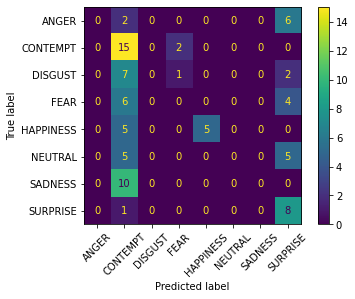

              precision    recall  f1-score   support

       ANGER       0.00      0.00      0.00         8
    CONTEMPT       0.29      0.88      0.44        17
     DISGUST       0.00      0.00      0.00        10
        FEAR       0.00      0.00      0.00        10
   HAPPINESS       1.00      0.50      0.67        10
     NEUTRAL       0.00      0.00      0.00        10
     SADNESS       0.00      0.00      0.00        10
    SURPRISE       0.32      0.89      0.47         9

    accuracy                           0.33        84
   macro avg       0.20      0.28      0.20        84
weighted avg       0.21      0.33      0.22        84



In [83]:
# Best C values: 85 160 564
model = LinearSVC(penalty='l2', C=85, max_iter=10000)
model.fit(train_x, train_y)
pred_y = model.predict(test_x)

show_metrics(model, pred_y, test_x, test_y)

Accuracy: 0.36904761904761907


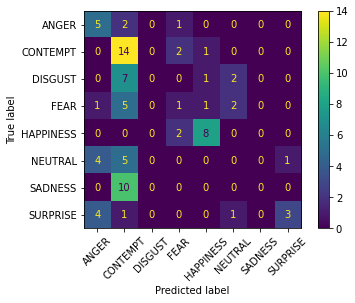

              precision    recall  f1-score   support

       ANGER       0.36      0.62      0.45         8
    CONTEMPT       0.32      0.82      0.46        17
     DISGUST       0.00      0.00      0.00        10
        FEAR       0.17      0.10      0.12        10
   HAPPINESS       0.73      0.80      0.76        10
     NEUTRAL       0.00      0.00      0.00        10
     SADNESS       0.00      0.00      0.00        10
    SURPRISE       0.75      0.33      0.46         9

    accuracy                           0.37        84
   macro avg       0.29      0.34      0.28        84
weighted avg       0.29      0.37      0.29        84



In [86]:
# Best parameters: (C=91, degree=4, kernel='poly')

model = SVC(C=82, degree=8, kernel='poly')
model.fit(train_x, train_y)
pred_y = model.predict(test_x)
show_metrics(model, pred_y, test_x, test_y)

Accuracy: 0.4642857142857143


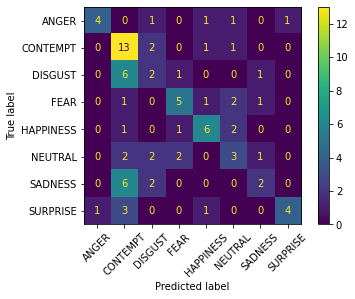

              precision    recall  f1-score   support

       ANGER       0.80      0.50      0.62         8
    CONTEMPT       0.41      0.76      0.53        17
     DISGUST       0.22      0.20      0.21        10
        FEAR       0.56      0.50      0.53        10
   HAPPINESS       0.60      0.60      0.60        10
     NEUTRAL       0.33      0.30      0.32        10
     SADNESS       0.40      0.20      0.27        10
    SURPRISE       0.80      0.44      0.57         9

    accuracy                           0.46        84
   macro avg       0.51      0.44      0.45        84
weighted avg       0.50      0.46      0.46        84



In [87]:
np.random.seed(42)

model = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=5),learning_rate= 2.154)
model.fit(train_x, train_y)
pred_y = model.predict(test_x)

show_metrics(model, pred_y, test_x, test_y)

In [93]:
tfeid_x = preprocess(tfeid_images)
tfeid_x = extract_features(tfeid_x, method=lbp)
tfeid_labels = np.array(tfeid_labels)

train_x, test_x, train_y, test_y = train_test_split(tfeid_x, tfeid_labels, stratify=tfeid_labels)

Accuracy: 0.34523809523809523


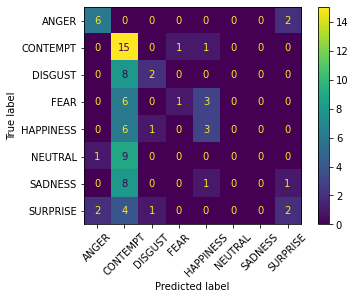

              precision    recall  f1-score   support

       ANGER       0.67      0.75      0.71         8
    CONTEMPT       0.27      0.88      0.41        17
     DISGUST       0.50      0.20      0.29        10
        FEAR       0.50      0.10      0.17        10
   HAPPINESS       0.38      0.30      0.33        10
     NEUTRAL       0.00      0.00      0.00        10
     SADNESS       0.00      0.00      0.00        10
    SURPRISE       0.40      0.22      0.29         9

    accuracy                           0.35        84
   macro avg       0.34      0.31      0.27        84
weighted avg       0.32      0.35      0.27        84



In [94]:
model = SVC(C=82, degree=8, kernel='poly')
model.fit(train_x, train_y)
pred_y = model.predict(test_x)
show_metrics(model, pred_y, test_x, test_y)

Accuracy: 0.42857142857142855


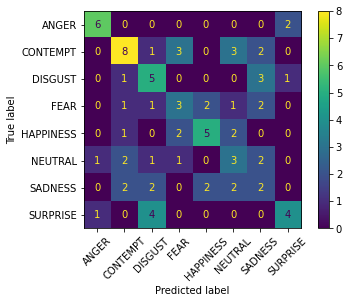

              precision    recall  f1-score   support

       ANGER       0.75      0.75      0.75         8
    CONTEMPT       0.53      0.47      0.50        17
     DISGUST       0.36      0.50      0.42        10
        FEAR       0.33      0.30      0.32        10
   HAPPINESS       0.56      0.50      0.53        10
     NEUTRAL       0.27      0.30      0.29        10
     SADNESS       0.18      0.20      0.19        10
    SURPRISE       0.57      0.44      0.50         9

    accuracy                           0.43        84
   macro avg       0.44      0.43      0.44        84
weighted avg       0.44      0.43      0.43        84



In [95]:
np.random.seed(42)

model = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=5),learning_rate= 2.154)
model.fit(train_x, train_y)
pred_y = model.predict(test_x)

show_metrics(model, pred_y, test_x, test_y)